# Read in a csv file from exoplanets.org 
# and allow some simple comparisons.

In [1]:
% matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 5
from matplotlib.font_manager import FontProperties
import scipy.integrate as integrate
import csv
import math
import numpy as np
import pylab as p
#import my_fns

In [2]:
# Constants in SI units
Msun, Rsun = 1.99E30, 6.96E8
Mjup, Rjup = 1.90E27 ,6.99E7
Mearth, Rearth = 5.972e24, 6.371e6
au = 1.496e+11
mproton = 1.673E-27
h = 6.62607004e-34
c = 299792458
k = 1.38064852e-23
G = 6.67408e-11

### Reading function

'System': name

'Teff': Effective temperature (K)

'[Fe/H]': Metallicity (dex)

'M_A': Mass of the star (Msun)

'R_A': Radius of star (Rsun)

'loggA': log surface gravity of the star (cgs)

'rho_A': density of star (rhosun)

'Period': (days)

'e': eccentricity

'a(AU)': separation (AU)

'M_b': Mass of planet (Mjup)

'R_b': Radius of planet (Rjup)

'g_b': Planet gravity (m/s^2)

'rho_b': Density (rhojup)

'Teq': Equilibrium Temperature (K)

'Discovery_reference': Discovery

'Recent_reference': Latest reference

In [3]:
def read_exodata(csv_file='allplanets-tepcat.csv'):
    with open(csv_file, 'r') as g:
        reader = csv.reader(g, delimiter=',')
        header = [ name.strip() for name in reader.next() ]
        #units = reader.next()
        yield header
        for row in reader:

            store = []
            for el in row:
                el = el.strip()
                try: el = float(el)
                except ValueError: pass #leave string
                store.append(el)
            row = store
        
            data_dict = dict(list(zip(header, row)))
            yield data_dict

In [4]:
def get_arrays(exo_data, hnames=['System', 'Teff', '[Fe/H]', 'M_A', 'R_A', 'loggA', 'rho_A', 'Period', \
                           'e', 'a(AU)', 'M_b', 'R_b', 'g_b', 'rho_b', 'Teq', \
                           'Discovery_reference', 'Recent_reference'], \
              need=['System']):
    # Returns a dictionary of the requested parameter arrays, 
    # dictionary contains all the parameters listed in hnames
    rejects = []
    
    out_dict = {}
    for i in range(len(hnames)):
        out_dict[hnames[i]] = []
        
    for line in exo_data:
        # check that we have all hnames
        need_vals = [ line[hname] for hname in need ]
        if np.any([ val == -1. for val in need_vals]): 
            rejects.append(line['System'])
            continue
        try:
            vals = [ line[hname] for hname in hnames ]
        except KeyError: # value missing
            continue

        for i in range(len(hnames)): out_dict[hnames[i]].append(vals[i])
            
    for i in range(len(hnames)):
        out_dict[hnames[i]] = np.array(out_dict[hnames[i]])
        
    out_dict['rejects'] = rejects
    return out_dict

In [5]:
def get_planet(name, od):
    # get dictionary of one planet's parameters from csv dictionary
    try: names = list(od['NAME'])
    except KeyError: names = list(od['System'])
    ind = names.index(name)
    return dict([ (var, od[var][ind]) for var in od if var != 'rejects'])

In [6]:
def get_tepcat_planets():
    exo_data = read_exodata('allplanets-tepcat.csv')
    header = exo_data.next()
    od = get_arrays(exo_data, need=['System', 'M_b', 'R_b', 'Teq', 'a(AU)', 'R_A', 'Period'])

    exo_data2 = read_exodata('observables_tepcat.csv')
    header = exo_data2.next()
    od2 = get_arrays(exo_data2, hnames=['System', 'Vmag', 'Kmag'])

    indexes2 = [ list(od2['System']).index(name) for name in od['System'] ]
    
    od['Vmag'] = od2['Vmag'][indexes2]; od['Kmag'] = od2['Kmag'][indexes2]
    return od

### Test TEPCat

In [34]:
exo_data = read_exodata('allplanets-tepcat.csv')
header = exo_data.next()
print header
print

od = get_arrays(exo_data)
print get_planet('WASP-018', od)

['System', 'Teff', 'err', 'err', '[Fe/H]', 'erru', 'errd', 'M_A', 'errup', 'errdn', 'R_A', 'errup', 'errdn', 'loggA', 'errup', 'errdn', 'rho_A', 'errup', 'errdn', 'Period', 'e', 'errup', 'errdown', 'a(AU)', 'errup', 'errdown', 'M_b', 'errup', 'errdn', 'R_b', 'errup', 'errdn', 'g_b', 'errup', 'errdn', 'rho_b', 'errup', 'errdn', 'Teq', 'err', 'err', 'Discovery_reference', 'Recent_reference']

{'loggA': 4.353, 'rho_A': 0.655, 'Teff': 6400.0, 'rho_b': 5.64, 'M_b': 10.52, 'M_A': 1.295, 'System': 'WASP-018', 'Period': 0.941, 'a(AU)': 0.02055, '[Fe/H]': 0.1, 'R_A': 1.255, 'Teq': 2411.0, 'R_b': 1.204, 'Recent_reference': '2013MNRAS.428.2645M', 'g_b': 179.9, 'e': 0.0092, 'Discovery_reference': '2009Natur.460.1098H'}


### Plotting function

In [35]:
def plot_arrays(x, y, z=None, xlabel='', ylabel='', zlabel='', title='', names=None, vmin=None, vmax=None, 
                invert_z=False, show=True, txmin=None, txmax=None, tymin=None, tymax=None,
                ylim=None, xlim=None, fontsize=None):
    # For making quick plots of certain parameters / SNRs
    p.scatter(x, y, marker='o', c=z, cmap='hot_r', vmin=vmin, vmax=vmax)
    if not names is None:
        font0 = FontProperties()
        font1 = font0.copy()
        if not fontsize is None: font1.set_size(fontsize)
        for xi, yi, ni in zip(x,y,names):
            if xi < txmin and not txmin is None: continue
            elif xi > txmax and not txmax is None: continue
            elif yi < tymin and not tymin is None: continue
            elif yi > tymax and not tymax is None: continue
            if not xlim is None:
                if xi < xlim[0] or xi > xlim[1]: continue
            if not ylim is None:
                if yi < ylim[0] or yi > ylim[1]: continue
            p.text(xi,yi,ni, fontproperties=font1)
                
    p.xlabel(xlabel)
    p.ylabel(ylabel)
    p.title(title)
    if not xlim is None: p.xlim(xlim)
    if not ylim is None: p.ylim(ylim)
    if not z is None:
        cbar = p.colorbar()
        cbar.set_label(zlabel)
        if invert_z: cbar.ax.invert_xaxis()
    if show: p.show()

### Table function

In [36]:
def table_arrays(headers, arrays, savefile='table.txt', sort=None, reverse=False, units=None):
    # Save results to a table
    #my_fns.silentremove(savefile)
    with open(savefile, 'w') as g:
        g.write('\t\t'.join(headers)+'\n')
        if not units is None: g.write('\t\t'.join(units)+'\n')
        if sort:
            i = headers.index(sort)
            _, indexes = zip(*sorted(zip(arrays[i], np.arange(len(arrays[i]))),reverse=reverse))
            indexes = [int(i) for i in indexes]
            arrays = [np.array(array)[indexes] for array in arrays]
        lines = ['\t\t'.join([str(item) for item in things])+'\n' for things in zip(*arrays)]
        for line in lines:
            g.write(line)      
    return

### Calculations

#### For transmission

In [37]:
def calc_eq_temp(a, Ts, Rs, A=0):
    '''Assume parameters in SI units'''
    # No redistribution, otherwise just math.sqrt(Rs/a/2.)*Ts
    return np.sqrt(np.divide(Rs,a)/2.)*Ts*(2**0.25) * (1-A)**0.25

def calc_surface_g(M, R):
    '''Returns surface g in SI'''
    G = 6.67E-11
    return G*M/R**2

def calc_scale_h(T,g,mu=1.2):
    '''
    Calculate atmospheric scale height,
    data should be in SI units.
    '''
    k = 1.38064852E-23
    return k*T/g/(mu*mproton)

def calc_transit_depth(sh, Rp, Rs, nsh=1):
    return 2*nsh*sh*Rp/(Rs**2)

def weins_peak(T):
    b = 2.8977729e-3 # m/K
    return b/T*1e6 # in micron

In [38]:
# Atmosphere sanity checks
# HJ
Tp = 2000
mu = 2.2*mproton
Mp = 1*Mjup
Rp = 1*Rjup
g = G*Mp/Rp**2
sh = k*Tp/mu/g
Rs = 1*Rsun
depth = calc_transit_depth(sh, Rp, Rs, nsh=1)
print 'HJ', depth

# Super Earth
Tp = 500
mu = 14*mproton
Mp = 6.6*6e24
Rp = 2.7*6e6
g = G*Mp/Rp**2
sh = k*Tp/mu/g
Rs = 0.2*Rsun
depth = calc_transit_depth(sh, Rp, Rs, nsh=1)
print 'Super Earth', depth

# Earth
Tp = 380
mu = 30*mproton
Mp = 6e24
Rp = 6e6
g = G*Mp/Rp**2
sh = k*Tp/mu/g
Rs = 1*Rsun
depth = calc_transit_depth(sh, Rp, Rs, nsh=1)
print 'Earth', depth

HJ 8.34242940366e-05
Super Earth 4.89372019219e-05
Earth 2.32794192468e-07


In [39]:
# Transit
print 'HJ: {:.2f}%'.format((Rjup/Rsun)**2*100)
print 'Super-Earth: {:.2f}%'.format((0.2*Rjup/Rsun/0.2)**2*100)
print 'Earth: {:.2f}%'.format((0.1*Rjup/Rsun)**2*100)

HJ: 1.01%
Super-Earth: 1.01%
Earth: 0.01%


#### For emission

In [40]:
def bb(l, T):
    # the energy per unit time (or the power) radiated per unit area of emitting surface 
    # in the normal direction per unit solid angle by a black body at temperature T at wavelength l
    h = 6.62607004E-34; c = 2.99792458E8; k = 1.38064852E-23 # S.I. units
    return 2*h*c**2 / l**5 / (np.exp(h*c/l/k/T)-1)

def bb_flux(T, R, band=None, l1=1e-6,l2=2e-6):
    # calculate flux in units of J/s in a given band
    if band == 'V':
        l1, l2 = (551-88)*10**-9, (551+88)*10**-9
    elif band == 'B':
        l1, l2 = (445-47)*10**-9, (445+47)*10**-9
    elif band == 'J':
        l1, l2 = (1.235-0.081)*10**-6, (1.235+0.081)*10**-6
    elif band == 'H':
        l1, l2 = (1.662-0.1255)*10**-6, (1.662+0.1255)*10**-6
    elif band == 'K':
        l1, l2 = (2.159-0.131)*10**-6, (2.159+0.131)*10**-6
    elif band == 'G102':
        l1, l2 = .800*10**-6, 1.150*10**-6
    elif band == 'G141':
        l1, l2 = 1.075*10**-6, 1.700*10**-6
    elif band == 'Spitzer1':
        l1, l2 = 3.1*10**-6, 4.1*10**-6
    elif band is None:
        print 'No band supplied, default to 1-2micron'
    I, error = integrate.quad(bb, l1, l2, args=T)
    F = I*np.pi*R**2 * 2*np.pi #2pi solidangle, piR^2 area
    return F

def eclipse_depth(Tp, Ts, Rp, Rs, band):
    try:
        Fp = np.array([ bb_flux(tp, rp, band) for tp, rp in zip(Tp, Rp)])
        Fs = np.array([ bb_flux(ts, rs, band) for ts, rs in zip(Ts, Rs)])
    except TypeError: # not iterable
        Fp = bb_flux(Tp, Rp, band)
        Fs = bb_flux(Ts, Rs, band) # J/s/solidangle
    return Fp/Fs

def reflected_depth(Ts, Rp, Rs, a, band, A=1):
    try:
        Fs = np.array([ bb_flux(ts, rs, band) for ts, rs in zip(Ts, Rs)])
    except TypeError: # not iterable
        Fs = bb_flux(Ts, Rs, band)
    Fp = Fs * (Rp/a)**2 * A
    return Fp/Fs

def emission_over_reflection(Tp, Ts, Rp, Rs, a, l, A=1):
    # calculate the emitted/relected flux for given parameters at a given wavelength
    # Note: albedo for reflected component may not be the same as that used 
    # to calculate eq temperature.
    try:
        Fp_ref = (Rp/a)**2 * A * np.array([ bb(l,ts) for ts in Ts ])
        Fp_em = np.array([bb(l,tp) for tp in Tp])
    except TypeError:
        Fp_ref = (Rp/a)**2 * A * bb(l,Ts)
        Fp_em = bb(l,Tp)
    return Fp_em/Fp_ref

def reflected_frac(Tp, Ts, Rp, Rs, a, l, A=1):
    # calculate the fraction of relected flux for given parameters at a given wavelength
    # Note: albedo for reflected component may not be the same as that used 
    # to calculate eq temperature.
    try:
        Fp_ref = (Rp/a)**2 * A * np.array([ bb(l,ts) for ts in Ts ])
        Fp_em = np.array([bb(l,tp) for tp in Tp])
    except TypeError:
        Fp_ref = (Rp/a)**2 * A * bb(l,Ts)
        Fp_em = bb(l,Tp)
    return Fp_ref/(Fp_ref+Fp_em)

## Write a quick file with all TEPCat names

In [41]:
exo_data = read_exodata('allplanets-tepcat.csv')
header = exo_data.next()
od = get_arrays(exo_data, need=['System'])
names = od['System']

#with open('tepcat_names.dat', 'w') as g:
#    for name in names:
#        if name[-1] in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']: name = name[:-1]
#        g.write(name)
#        g.write('\n')

In [42]:
exo_data = read_exodata('observables_tepcat.csv')
header = exo_data.next()
od2 = get_arrays(exo_data, hnames=['System', 'Vmag', 'Kmag'])
print od2

{'rejects': [], 'Kmag': array([ 4.01, 13.5 , 12.15, ..., 10.43, 10.43, 12.5 ]), 'System': array(['55_Cnc_e', 'AD_3116', 'CoRoT-01', ..., 'Kepler-450c',
       'Kepler-450d', 'KOI-179'], dtype='|S14'), 'Vmag': array([ 5.95, 18.73, 13.6 , ..., 11.76, 11.76, 14.  ])}


In [43]:
# Check the list of names is the same

print 'Catalogue lengths:', len(od['System']), len(od2['System'])
print 'Planets missmatched between catalogues:'
for name1, name2 in zip(od['System'],od2['System']):
    
    if name1 == name2: pass
    else: print name1, '-', name2
# Two of the EPIC planets are switched...
# and there are a bunch of KOIs and stuff in the "observables" table

Catalogue lengths: 675 1506
Planets missmatched between catalogues:
EPIC_201702477 - EPIC_201295312
EPIC_201295312 - EPIC_201702477


In [44]:
print od2['System'][-1]

KOI-179


# Look at specific planets

In [45]:
od = get_tepcat_planets()

od['g'] = calc_surface_g(od['M_b']*Mjup, od['R_b']*Rjup)
od['TEQ'] = calc_eq_temp(od['a(AU)']*au, od['Teff'], od['R_A']*Rsun, A=0)
od['SH'] = calc_scale_h(od['TEQ'], od['g'])

print od['rejects']

['AD_3116', 'CoRoT-16', 'CoRoT-21', 'CoRoT-28', 'CoRoT-29', 'CoRoT-33', 'EPIC_201702477', 'EPIC_201295312', 'EPIC_210363145', 'EPIC_211916756', 'EPIC_228732031', 'K2-002', 'K2-003b', 'K2-003c', 'K2-003d', 'K2-010b', 'K2-019b', 'K2-019c', 'K2-019d', 'K2-021b', 'K2-021c', 'K2-025b', 'K2-026b', 'K2-028', 'K2-031', 'K2-033', 'K2-093b', 'K2-093c', 'K2-095', 'K2-097', 'K2-099', 'K2-100', 'K2-101', 'K2-102', 'K2-103', 'K2-104', 'K2-105', 'K2-132', 'K2-136b', 'K2-136c', 'K2-136d', 'K2-138b', 'K2-138c', 'K2-138d', 'K2-138e', 'K2-138f', 'K2-141c', 'Kepler-009b', 'Kepler-009c', 'Kepler-009d', 'Kepler-011b', 'Kepler-011c', 'Kepler-011d', 'Kepler-011e', 'Kepler-011f', 'Kepler-011g', 'Kepler-018b', 'Kepler-018c', 'Kepler-018d', 'Kepler-019b', 'Kepler-025b', 'Kepler-025c', 'Kepler-026b', 'Kepler-026c', 'Kepler-029b', 'Kepler-029c', 'Kepler-030b', 'Kepler-030c', 'Kepler-030d', 'Kepler-034', 'Kepler-035', 'Kepler-037b', 'Kepler-037c', 'Kepler-037d', 'Kepler-042b', 'Kepler-042c', 'Kepler-042d', 'Kepler-

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide


In [46]:
W18 = get_planet('WASP-018', od)
print W18

{'M_b': 10.52, 'System': 'WASP-018', 'g_b': 179.9, 'Vmag': 9.27, 'M_A': 1.295, 'Kmag': 8.13, 'a(AU)': 0.02055, 'TEQ': 2868.6479133793505, 'loggA': 4.353, 'Discovery_reference': '2009Natur.460.1098H', 'rho_b': 5.64, 'R_A': 1.255, 'rho_A': 0.655, 'R_b': 1.204, 'Recent_reference': '2013MNRAS.428.2645M', 'e': 0.0092, 'Teff': 6400.0, 'g': 188.22956966846345, 'Period': 0.941, 'SH': 104808.21951499172, '[Fe/H]': 0.1, 'Teq': 2411.0}


In [47]:
for planet in ['HD_189733', 'HD_209458', 'WASP-012', 'WASP-121', 'WASP-069', 'WASP-080', 'WASP-043',\
              'WASP-017', 'WASP-039', 'WASP-019', 'HAT-P-01', 'HAT-P-02', 'WASP-018']:
    try: 
        planet = get_planet(planet, od)
        print '{}\tVmag: {:.1f}\tPer: {} d\tTeq: {:.0f}'.format(planet['System'], planet['Vmag'], \
                                                                planet['Period'], planet['TEQ'])
    except ValueError: 
        print planet, '...'

HD_189733	Vmag: 7.7	Per: 2.219 d	Teq: 1417
HD_209458	Vmag: 7.7	Per: 3.525 d	Teq: 1736
WASP-012	Vmag: 11.7	Per: 1.091 d	Teq: 3047
WASP-121	Vmag: 10.5	Per: 1.275 d	Teq: 2805
WASP-069	Vmag: 9.9	Per: 3.868 d	Teq: 1143
WASP-080	Vmag: 11.9	Per: 3.068 d	Teq: 982
WASP-043	Vmag: 12.4	Per: 0.813 d	Teq: 1714
WASP-017	Vmag: 11.5	Per: 3.735 d	Teq: 2086
WASP-039	Vmag: 12.1	Per: 4.055 d	Teq: 1344
WASP-019	Vmag: 12.3	Per: 0.789 d	Teq: 2472
HAT-P-01	Vmag: 10.4	Per: 4.465 d	Teq: 1575
HAT-P-02	Vmag: 8.7	Per: 5.633 d	Teq: 1801
WASP-018	Vmag: 9.3	Per: 0.941 d	Teq: 2869


# Transmission

## Transit depths

In [55]:
od = get_tepcat_planets()

od['g'] = calc_surface_g(od['M_b']*Mjup, od['R_b']*Rjup)
od['TEQ'] = calc_eq_temp(od['a(AU)']*au, od['Teff'], od['R_A']*Rsun, A=0)
od['SH'] = calc_scale_h(od['TEQ'], od['g'])
od['ATMDEPTH'] = calc_transit_depth(od['SH'], od['R_b']*Rjup, od['R_A']*Rsun)

print len(od['ATMDEPTH'])
print len(od['System'])
print len(od['Kmag'])

439
439
439


/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide


In [56]:
planet = get_planet('HAT-P-02', od)
print planet
print calc_eq_temp(0.048019*au, 6290,1.506*Rsun)
print 1.157*Rjup / 1.51/Rsun

{'M_b': 8.74, 'System': 'HAT-P-02', 'g_b': 152.0, 'Vmag': 8.71, 'M_A': 1.279, 'Kmag': 7.6, 'a(AU)': 0.0674, 'ATMDEPTH': 9.415363764827353e-06, 'TEQ': 1801.1781178450515, 'loggA': 4.092, 'Discovery_reference': '2007ApJ...670..826B', 'rho_b': 5.1, 'Teq': 1516.0, 'rho_A': 0.268, 'R_b': 1.19, 'Recent_reference': '2010MNRAS.408.1689S', 'e': 0.5091, 'Teff': 6290.0, 'g': 160.08203378796603, 'Period': 5.633, 'SH': 77378.44780494198, '[Fe/H]': 0.14, 'R_A': 1.68}
2020.4025115335976
0.0769527860242



## H band scaling (WFC3/G141)

Scaling noise to transit obervations of GJ1214b, precision of 70 ppm for one visit.
Transit duration not taken into account.

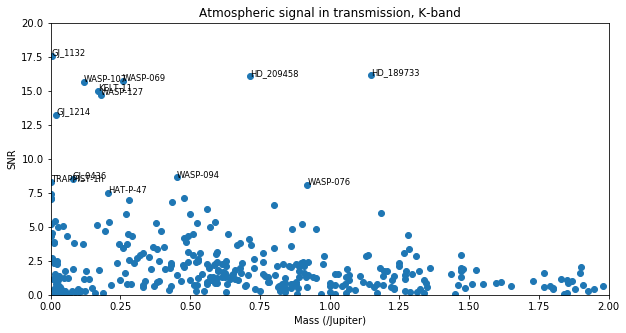

In [58]:
scale_N = 70e-6
scale_ind = list(od['System']).index('GJ_1214')
scale_mag = od['Kmag'][scale_ind]
od['TSNR_H'] =  (10**(-(od['Kmag']-scale_mag)/2.5/2.))*od['ATMDEPTH'] / scale_N

Ms, SNRs, ds, names, Hmags, Gs, Teqs, Ps = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t, per 
                            in zip(od['M_b'], od['TSNR_H'], od['ATMDEPTH'], od['System'], 
                            od['Kmag'], od['g'], od['TEQ'], od['Period']) if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', xlim=[0.,2], fontsize = 'small', show=False,
           names=names, tymin=7.5, ylim=[0,20], title='Atmospheric signal in transmission, K-band')
p.savefig('./transit/transit_snr_H.png')
p.show()

if True:
    table_arrays(['Name','Hmag','AtmDepth (ppm)','SNR', 'Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(h) for h in Hmags], [int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs], ['{:.2f}'.format(per) for per in Ps],
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs],
            ['{:.0f}'.format(t) for t in Teqs]], 
             savefile='./transit/transit_snr_K.txt', sort='SNR', reverse=True)

## V band scaling (HST/STIS)

Scale precision to HD209458 b observations by Charbonneau et al (2002) of NaI line.

Photon noise limited, to about 30 ppm over 3 transits -> 52 ppm per transit.

This is then the SNR of the NaI lines for instance, not the white-light curve.

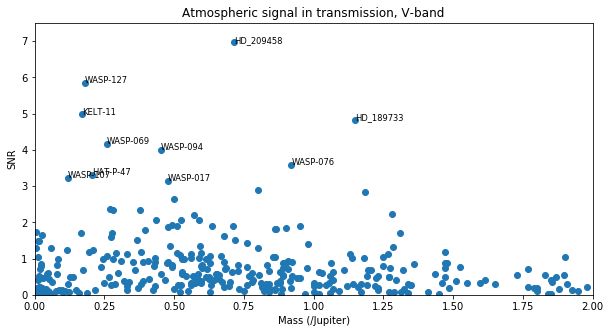

In [59]:
scale_N = 52e-6
scale_ind = list(od['System']).index('HD_209458')
scale_Vmag = od['Vmag'][scale_ind]
od['TSNR_H'] =  (10**(-(od['Vmag']-scale_Vmag)/2.5/2.))*od['ATMDEPTH'] / scale_N

Ms, SNRs, ds, names, Vmags, Gs, Teqs, Ps = zip(*[ (m, snr, d, ni, v, g, t, per) 
                                               for m, snr, d, ni, v, g, t, per in 
                                zip(od['M_b'], od['TSNR_H'], od['ATMDEPTH'], 
                                    od['System'], od['Vmag'], od['g'], od['TEQ'], od['Period'])
                                  if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', xlim=[0.,2], fontsize = 'small', show=False,
           names=names, tymin=3., ylim=[0,7.5], title='Atmospheric signal in transmission, V-band')

p.savefig('./transit/transit_snr_V.png')
p.show()

if True:
    table_arrays(['Name','Vmag','AtmDepth (ppm)','SNR', 'Period', 'Mass', 'logg', 'Eq Temp'], 
             [names,[ '{:.2f}'.format(v) for v in Vmags],
            [int(d) for d in np.array(ds)*1e6], [float('{:.1f}'.format(snr)) for snr in SNRs], 
            ['{:.2f}'.format(per) for per in Ps], [ '{:.2f}'.format(m) for m in Ms], 
            ['{:.2f}'.format(np.log(g)) for g in Gs], ['{:.0f}'.format(t) for t in Teqs]],
             savefile='./transit/transit_snr_V.txt', sort='SNR', reverse=True)

# Secondary Eclipse

## Eclipsed depths for emission and reflection in V & H

In [60]:
od = get_tepcat_planets()

od['g'] = calc_surface_g(od['M_b']*Mjup, od['R_b']*Rjup)
od['TEQ'] = calc_eq_temp(od['a(AU)']*au, od['Teff'], od['R_A']*Rsun, A=0)

band = 'K'
od['EDE_K'] = eclipse_depth(od['TEQ'], od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, band=band)
od['EDR_K'] = reflected_depth(od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, od['a(AU)']*au, band=band, A=1)

band = 'V'
od['EDE_V'] = eclipse_depth(od['TEQ'], od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun, band=band)
od['EDR_V'] = reflected_depth(od['Teff'], od['R_b']*Rjup, od['R_A']*Rsun,  od['a(AU)']*au, band=band, A=1)

## H band scaling (WFC3/G141)

Scaling noise to eclipse obervations of GJ1214 b precision of 70 ppm for one visit.
Transit duration not taken into account.

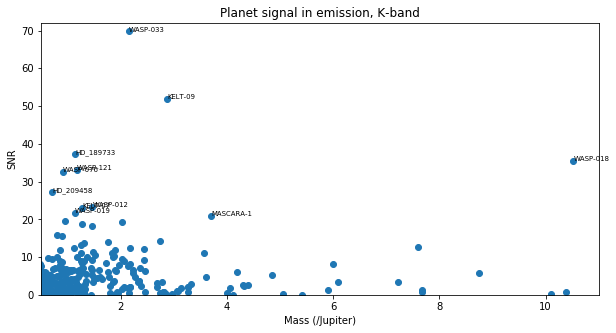

In [61]:
scale_N = 70e-6
scale_ind = list(od['System']).index('GJ_1214')
scale_mag = od['Kmag'][scale_ind]
od['EESNR_K'] =  (10**(-(od['Kmag']-scale_mag)/2.5/2.))*od['EDE_K'] / scale_N

Ms, SNRs, ds, names, Hmags, Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t, per 
                            in zip(od['M_b'], od['EESNR_K'], od['EDE_K'], 
                            od['System'], od['Kmag'], od['g'], od['TEQ'], od['Period'])
                        if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in emission, K-band', 
            names=names, tymin=20, xlim=[0.5,11], ylim=[0,72])
p.savefig('./emission/emission_snr_H.png')
p.show()

if True:
    table_arrays(['Name','Hmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
             [names,[ '{:.2f}'.format(h) for h in Hmags],[int(d) for d in np.array(ds)*1e6],
             [float('{:.1f}'.format(snr)) for snr in SNRs], ['{:.2f}'.format(per) for per in Ps], 
             [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
             ['{:.0f}'.format(t) for t in Teqs]],
             savefile='./emission/emission_snr_H.txt', sort='SNR', reverse=True)

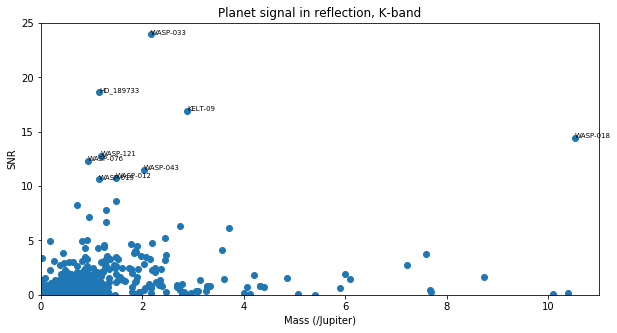

In [62]:
scale_N = 70e-6
scale_ind = list(od['System']).index('GJ_1214')
scale_mag = od['Kmag'][scale_ind]
od['ERSNR_K'] =  (10**(-(od['Kmag']-scale_mag)/2.5/2.))*od['EDR_K'] / scale_N

Ms, SNRs, ds, names, Hmags, Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t ,per 
                            in zip(od['M_b'], od['ERSNR_K'], od['EDR_K'], 
                            od['System'], od['Kmag'],od['g'], od['TEQ'], od['Period'])
                            if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in reflection, K-band', 
            names=names, tymin=10, xlim=[0.,11], ylim=[0,25])
p.savefig('./reflection/reflection_snr_H.png')
p.show()

if True:
    table_arrays(['Name','Hmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(h) for h in Hmags],[int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs],['{:.2f}'.format(per) for per in Ps], 
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
            ['{:.0f}'.format(t) for t in Teqs]], 
            savefile='./reflection/reflection_snr_H.txt', sort='SNR', reverse=True)

In [63]:
trappists = [ get_planet(name, od) for name in od['System'] if name.startswith('TRAPPIST')]
print [trap['System'] for trap in trappists]

print trappists[-1]

['TRAPPIST-1b', 'TRAPPIST-1c', 'TRAPPIST-1d', 'TRAPPIST-1e', 'TRAPPIST-1f', 'TRAPPIST-1g', 'TRAPPIST-1h']
{'EDR_V': 2.7541481985322355e-07, 'M_b': 0.0003, 'System': 'TRAPPIST-1h', 'EDR_K': 2.7541481985322355e-07, 'g_b': -1.0, 'EESNR_K': 2.054471449353114e-12, 'ERSNR_K': 0.0019538412107534043, 'Vmag': 18.8, 'M_A': 0.089, 'Kmag': 10.3, 'Teq': 169.2, 'a(AU)': 0.0617, 'TEQ': 201.68710861652258, 'loggA': -1.0, 'Discovery_reference': '2017NatAs...1E.129L', 'rho_b': -1.0, 'EDE_V': 5.3771770247398535e-49, 'EDE_K': 2.8959972847486066e-16, 'rho_A': 51.1, 'R_b': 0.0693, 'Recent_reference': 'arXiv:1801.02554', 'e': 0.0, 'Teff': 2511.0, 'g': 1.6202419369032597, 'Period': 18.768, '[Fe/H]': 0.04, 'R_A': 0.121}


## V band scaling (HST/STIS)

Scale precision to HD209458 b white-light curve by Brown et al (2001).

About 110 ppm per transit.

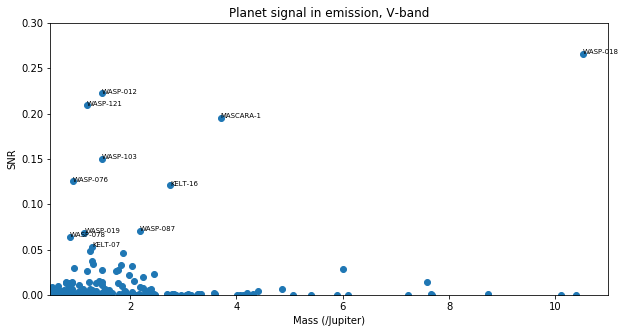

In [64]:
scale_N = 110e-6
scale_ind = list(od['System']).index('HD_209458')
scale_Vmag = od['Vmag'][scale_ind]
od['EESNR_V'] =  (10**(-(od['Vmag']-scale_Vmag)/2.5/2.))*od['EDE_V'] / scale_N

Ms, SNRs, ds, names, Vmags,  Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                 for m, snr, d, ni, h, g, t ,per 
                            in zip(od['M_b'], od['EESNR_V'], od['EDE_V'], 
                            od['System'], od['Vmag'],od['g'], od['TEQ'], od['Period'])
                        if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in emission, V-band', 
            names=names, tymin=0.05, xlim=[0.5,11], ylim=[0,0.3])
p.savefig('./emission/emission_snr_V.png')
p.show()

if True:
    table_arrays(['Name','Vmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(v) for v in Vmags], [int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs],['{:.2f}'.format(per) for per in Ps], 
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
            ['{:.0f}'.format(t) for t in Teqs]], 
            savefile='./emission/emission_snr_V.txt', sort='SNR', reverse=True)

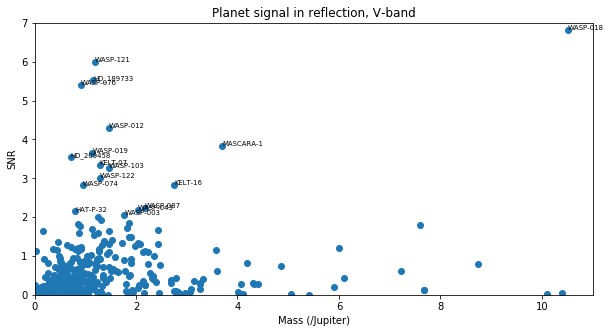

In [65]:
scale_N = 110e-6
scale_ind = list(od['System']).index('WASP-018')
scale_Vmag = od['Vmag'][scale_ind]
od['ERSNR_V'] =  (10**(-(od['Vmag']-scale_Vmag)/2.5/2.))*od['EDR_V'] / scale_N

Ms, SNRs, ds, names, Vmags, Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t, per 
                            in zip(od['M_b'], od['ERSNR_V'], od['EDR_V'], 
                            od['System'], od['Vmag'],od['g'], od['TEQ'], od['Period'])
                        if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in reflection, V-band', 
            names=names, tymin=2, xlim=[0.,11], ylim=[0,7])
p.savefig('./reflection/reflection_snr_V.png')
p.show()

if True:
    table_arrays(['Name','Vmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(v) for v in Vmags], [int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs], ['{:.2f}'.format(per) for per in Ps], 
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
            ['{:.0f}'.format(t) for t in Teqs]], 
            savefile='./reflection/reflection_snr_V.txt', sort='SNR', reverse=True)

# No B band magnitudes from TEPCat

So this code will not run.

## B band scaling (HST/STIS)

Scale precision to HD189733 b albedo measurements by Evans et al.

290 - 450 nm : Ag = 0.40 (0.12)
450 - 570 nm : Ag = 0.00 (0.12)

In [87]:
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','V','BMV','PER'])
od['B'] = od['BMV'] + od['V']
od['TEQ'] = calc_eq_temp(od['A']*au, od['TEFF'], od['RSTAR']*Rsun, A=0)
od['g'] = calc_surface_g(od['MASS']*Mjup, od['R']*Rjup)

band = 'B'
od['EDE_B'] = eclipse_depth(od['TEQ'], oad['TEFF'], od['R']*Rjup, od['RSTAR']*Rsun, band=band)
od['EDR_B'] = reflected_depth(od['TEFF'], od['R']*Rjup, od['RSTAR']*Rsun,  od['A']*au, band=band, A=1)

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in divide


In [78]:
HD189 = get_planet('HD 189733 b', od)
print HD189
depth = 0.4 * ((HD189['R']*Rjup) / (HD189['A']*au))**2
precision = 0.12 * ((HD189['R']*Rjup) / (HD189['A']*au))**2

print depth*1e6, precision*1e6

{'A': 0.0309953, 'B': 8.6009999999999991, 'BMV': 0.93100000000000005, 'NAME': 'HD 189733 b', 'g': 22.904177778297214, 'RSTAR': 0.75600000000000001, 'PER': 2.2185756699999999, 'R': 1.1379999999999999, 'MASS': 1.1435999999999999, 'EDR_B': 0.00029429575662391459, 'V': 7.6699999999999999, 'TEQ': 1427.6601464281307, 'EDE_B': 3.1703315768874783e-09, 'TEFF': 5040.0}
117.71830265 35.3154907949


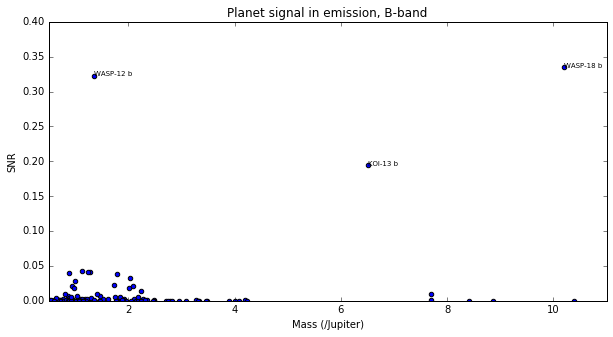

In [88]:
scale_ind = list(od['NAME']).index('HD 189733 b')
HD189 = get_planet('HD 189733 b', od)
scale_N = 0.12* ((HD189['R']*Rjup) / (HD189['A']*au))**2

scale_Bmag = od['B'][scale_ind]
od['EESNR_B'] =  (10**(-(od['B']-scale_Bmag)/2.5/2.))*od['EDE_B'] / scale_N

Ms, SNRs, ds, names, Bmags,  Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                 for m, snr, d, ni, h, g, t ,per 
                            in zip(od['MASS'], od['EESNR_B'], od['EDE_B'], 
                            od['NAME'], od['B'],od['g'], od['TEQ'], od['PER'])
                        if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in emission, B-band', 
            names=names, tymin=0.05, xlim=[0.5,11], ylim=[0,0.4])
p.savefig('./emission/emission_snr_B.png')
p.show()

table_arrays(['Name','Bmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(v) for v in Bmags], [int(d) for d in np.array(ds)*1e6],
            [float('{:.1f}'.format(snr)) for snr in SNRs],['{:.2f}'.format(per) for per in Ps], 
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
            ['{:.0f}'.format(t) for t in Teqs]], 
            savefile='./emission/emission_snr_B.txt', sort='SNR', reverse=True)

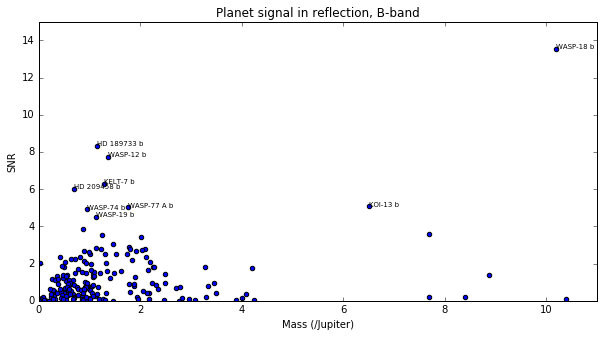

In [98]:
scale_ind = list(od['NAME']).index('HD 189733 b')
HD189 = get_planet('HD 189733 b', od)
scale_N = 0.12* ((HD189['R']*Rjup) / (HD189['A']*au))**2

scale_Bmag = od['B'][scale_ind]
od['ERSNR_B'] =  (10**(-(od['B']-scale_Bmag)/2.5/2.))*od['EDR_B'] / scale_N

Ms, SNRs, ds, names, Bmags, Gs, Teqs, Ps  = zip(*[ (m, snr, d, ni, h, g, t, per) 
                                                for m, snr, d, ni, h, g, t, per 
                            in zip(od['MASS'], od['ERSNR_B'], od['EDR_B'], 
                            od['NAME'], od['B'],od['g'], od['TEQ'], od['PER'])
                        if np.isfinite(snr) and m > 0.])
plot_arrays(Ms, SNRs, xlabel='Mass (/Jupiter)', ylabel='SNR', fontsize='x-small', 
            show=False, title='Planet signal in reflection, B-band', 
            names=names, tymin=4., xlim=[0.,11], ylim=[0,15])
p.savefig('./reflection/reflection_snr_B.png')
p.show()

table_arrays(['Name','Bmag','Eclipse depth (ppm)','SNR','Period', 'Mass', 'logg', 'Eq Temp'], 
            [names,[ '{:.2f}'.format(v) for v in Bmags], [int(d) for d in np.array(ds)*1e6],
            [float('{:.3g}'.format(snr)) for snr in SNRs], ['{:.2f}'.format(per) for per in Ps], 
            [ '{:.2f}'.format(m) for m in Ms], ['{:.2f}'.format(np.log(g)) for g in Gs], 
            ['{:.0f}'.format(t) for t in Teqs]], 
            savefile='./reflection/reflection_snr_B.txt', sort='SNR', reverse=True)

# Emission/Reflection

Calculate emitted/reflected flux in B, V, I, Z, H and K bands and quote the peak wavelength of the star and planet in each case. Use central wavelengths rather than integrating.

Make tables sorting by V, H and BB peak for planet.

In [66]:
A=0.5

exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','PER', 'V','H'])
od['TEQ'] = calc_eq_temp(od['A']*au, od['TEFF'], od['RSTAR']*Rsun, A=A)
od['PPEAK_L'] = weins_peak(od['TEQ'])
od['SPEAK_L'] = weins_peak(od['TEFF'])

central_l = {'B':445e-9, 'V':551e-9, 'I':806e-9, 'Z':900e-6, 'H':1.63e-6, 'K':2.19e-6}

for band in central_l:
    # calculate ratios
    od['EvsR_'+band] = emission_over_reflection(od['TEQ'], od['TEFF'], od['R']*Rjup, od['RSTAR']*Rsun,
                                                od['A']*au, l=central_l[band], A=A)
    
# make tables
# check for not finite values
allowed = np.isfinite(od['EvsR_V']) 
header = ['Name', 'Peak l planet', 'Peak l star']
units = ['-', 'micron', 'micron']
lines = [od['NAME'][allowed], [ float('{:.2f}'.format(l)) for l in od['PPEAK_L'][allowed]], 
         [ float('{:.2f}'.format(l)) for l in od['SPEAK_L'][allowed]]]
for band in central_l:
    lines.append([ float('{:.3f}'.format(ratio)) for ratio in od['EvsR_'+band][allowed]])
    header.append('Ratio in {}'.format(band))
    units.append('-')
lines += [[float('{:.2f}'.format(v)) for v in od['V'][allowed]], 
          [float('{:.2f}'.format(h)) for h in od['H'][allowed]], 
          [float('{:.2f}'.format(m)) for m in od['MASS'][allowed]], 
          [float('{:.2f}'.format(r)) for r in od['R'][allowed]], 
          [float('{:.2f}'.format(per)) for per in od['PER'][allowed]]]
header += ['Vmag','Hmag','Mp','Rp','Per']
units += ['-','-','Jupiter Mass', 'Jupiter Radius', 'days']

table_arrays(header, lines, units=units,
            savefile='emission_vs_reflection_bbp_{}.txt'.format(A), sort='Peak l planet', reverse=True)
table_arrays(header, lines, units=units,
            savefile='emission_vs_reflection_V_{}.txt'.format(A), sort='Ratio in V', reverse=True)
table_arrays(header, lines, units=units,
            savefile='emission_vs_reflection_H_{}.txt'.format(A), sort='Ratio in H', reverse=True)

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in divide


In [67]:
# Using SNR * f metric
A=0.5

exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','PER', 'V','H'])
od['TEQ'] = calc_eq_temp(od['A']*au, od['TEFF'], od['RSTAR']*Rsun, A=A)
od['PPEAK_L'] = weins_peak(od['TEQ'])
od['SPEAK_L'] = weins_peak(od['TEFF'])

central_l = {'B':445e-9, 'V':551e-9, 'I':806e-9, 'Z':900e-6, 'H':1.63e-6, 'K':2.19e-6}

scale_N_H = 70e-6 / (.76/.58)**0.5 # accounting for duty cycle change for bi-direction scan
scale_ind_H = list(od['NAME']).index('GJ 1214 b')
scale_Hmag = od['H'][scale_ind_H]
scale_N_V = 52e-6
scale_ind_V = list(od['NAME']).index('HD 209458 b')
scale_Vmag = od['V'][scale_ind_V]

# calculate ratios
od['EDE_V'] = eclipse_depth(od['TEQ'], od['TEFF'], od['R']*Rjup, od['RSTAR']*Rsun, band='V')
od['EDR_V'] = reflected_depth(od['TEFF'], od['R']*Rjup, od['RSTAR']*Rsun,  od['A']*au, band='V', A=A)
od['R_frac_V'] = od['EDR_V'] / (od['EDE_V']+od['EDR_V'])
od['SNR_V'] =  (10**(-(od['V']-scale_Hmag)/2.5/2.))*(od['EDE_V']+od['EDR_V']) / scale_N_V
od['M_V'] = od['R_frac_V'] * od['SNR_V'] / od['TEQ']

od['EDE_H'] = eclipse_depth(od['TEQ'], od['TEFF'], od['R']*Rjup, od['RSTAR']*Rsun, band='H')
od['EDR_H'] = reflected_depth(od['TEFF'], od['R']*Rjup, od['RSTAR']*Rsun, od['A']*au, band='H', A=A)
od['SNR_H'] =  (10**(-(od['H']-scale_Hmag)/2.5/2.))*(od['EDE_H']+od['EDR_H']) / scale_N_H
od['R_frac_H'] = od['EDR_H'] / (od['EDE_H']+od['EDR_H'])
od['M_H'] = od['R_frac_H'] * od['SNR_H'] / od['TEQ']

W80 = get_planet('WASP-80 b', od)
print W80
# make tables
# check for not finite values
allowed = np.isfinite(od['R_frac_V']) 
for band in ['V', 'H']:
    header = ['Name', 'M', 'f', 'SNR', 'Emitted', 'Reflected', 'Teq', 'Peak l star']
    units = ['-','(f*SNR/Teq)','%','-', 'ppm','ppm', 'K', 'micron']
    lines = [ [''.join(name.split()) for name in od['NAME'][allowed]], 
            [ float('{:.3g}'.format(metric)) for metric in od['M_'+band][allowed]],
            [ float('{:.1f}'.format(ratio*100)) for ratio in od['R_frac_'+band][allowed]],
            [ float('{:.1f}'.format(snr)) for snr in od['SNR_'+band][allowed]],
            [ float('{:.1f}'.format(depth*1e6)) for depth in od['EDE_'+band][allowed]],
            [ float('{:.1f}'.format(depth*1e6)) for depth in od['EDR_'+band][allowed]],
            [ float('{:d}'.format(int(t))) for t in od['TEQ'][allowed]],
            [ float('{:.2f}'.format(l)) for l in od['SPEAK_L'][allowed]] 
            ]
    table_arrays(header, lines, units=units,
            savefile='./reflection_metric_tables/reflection_fraction_{}_{}.txt'.format(band,A), sort='M', reverse=True)

    print './reflection_metric_tables/reflection_fraction_{}_{}.txt'.format(band,A)

{'EDR_V': 8.3265017591866057e-05, 'TEFF': 4145.0, 'RSTAR': 0.57099999999999995, 'PER': 3.0678504000000002, 'SPEAK_L': 0.69910082026538001, 'PPEAK_L': 3.5613614569435859, 'SNR_H': 1.881582915356691, 'MASS': 0.551763, 'TEQ': 813.66997847135485, 'EDR_H': 8.3265017591866057e-05, 'SNR_V': 0.48223556878636636, 'A': 0.034469600000000003, 'H': 8.5129999999999999, 'EDE_V': 1.0461342861345233e-12, 'R_frac_H': 0.94565772894986833, 'R_frac_V': 0.99999998743608898, 'M_H': 0.0021867998987868788, 'EDE_H': 4.7848286081221692e-06, 'V': 11.699999999999999, 'NAME': 'WASP-80 b', 'M_V': 0.0005926672674265057, 'R': 0.95199999999999996}
./reflection_metric_tables/reflection_fraction_V_0.5.txt
./reflection_metric_tables/reflection_fraction_H_0.5.txt


/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide


In [46]:
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','PER', 'V','H'])


exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od2 = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','PER', 'V','H', 'BMV'])

print len(od['NAME'])- len(od2['NAME']), 'planets without B-mag'
print
for name in od['NAME']:
    try: planet = get_planet(name, od2)
    except: print name,

35 planets without B-mag

WASP-127 b WASP-103 b WASP-10 b Kepler-424 b TRAPPIST-1 c WASP-42 b Kepler-69 b Kepler-308 c Kepler-423 b Kepler-45 b Kepler-308 b Kepler-223 c TRAPPIST-1 b HAT-P-18 b WASP-88 b WASP-96 b Kepler-61 b TRAPPIST-1 d HAT-P-19 b Kepler-69 c Kepler-41 b Kepler-199 b Kepler-223 d WASP-89 b HAT-P-39 b Kepler-199 c OGLE-TR-111 b WASP-64 b Kepler-223 e HAT-P-20 b WASP-47 b WASP-98 b Kepler-223 b WASP-47 d OGLE-TR-182 b


## Check G141 vs G102 for WASP-80b

Just use J-band, scale G141 to GJ1214, G102 to WASP-12

In [15]:
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','H','K','J', 'PER', 'V'])

A = 0.7

W80 = get_planet('WASP-80 b', od)
ind = list(od['NAME']).index('WASP-80 b')
print W80
print

scale_J_G141 = 70e-6 / (.76/.58)**0.5  / np.sqrt(20) # accounting for duty cycle change for bi-direction scan
GJ1214 = get_planet('GJ 1214 b', od)
scale_Jmag_G141 = GJ1214['J']

scale_J_G102 = 164e-6  /1.34*1.1 / np.sqrt(30) # 34% above photon noise -> 20%
print scale_J_G102*1e6
WASP12 = get_planet('WASP-12 b', od)
scale_Jmag_G102= WASP12['J']

W80['TEQ'] = calc_eq_temp(W80['A']*au, W80['TEFF'], W80['RSTAR']*Rsun, A=A)
W80['g'] = calc_surface_g(W80['MASS']*Mjup, W80['R']*Rjup)

band = 'G141'
ede_141 = eclipse_depth(W80['TEQ'], W80['TEFF'], W80['R']*Rjup, W80['RSTAR']*Rsun, band=band)
edr_141 = reflected_depth(W80['TEFF'], W80['R']*Rjup, W80['RSTAR']*Rsun,  W80['A']*au, band=band, A=A)
snr_141 = (10**(-(W80['J']-scale_Jmag_G141)/2.5/2.))*(ede_141+edr_141) / scale_J_G141

band = 'G102'
ede_102 = eclipse_depth(W80['TEQ'], W80['TEFF'], W80['R']*Rjup, W80['RSTAR']*Rsun, band=band)
edr_102 = reflected_depth(W80['TEFF'], W80['R']*Rjup, W80['RSTAR']*Rsun,  W80['A']*au, band=band, A=A)
snr_102 = (10**(-(W80['J']-scale_Jmag_G102)/2.5/2.))*(ede_102+edr_102) / scale_J_G102

print 'G102: Depth {:.1f}, SNR {:.2f}'.format((ede_102+edr_102)*1e6, snr_102)
print 'G141: Depth {:.1f}, SNR {:.2f}'.format((ede_141+edr_141)*1e6, snr_141)

{'A': 0.034469600000000003, 'NAME': 'WASP-80 b', 'RSTAR': 0.57099999999999995, 'H': 8.5129999999999999, 'K': 110.90000000000001, 'J': 9.218, 'PER': 3.0678504000000002, 'R': 0.95199999999999996, 'MASS': 0.551763, 'V': 11.699999999999999, 'TEFF': 4145.0}

24.5793903915
G102: Depth 116.6, SNR 8.47
G141: Depth 116.8, SNR 10.91


In [16]:
print snr_102 / snr_141

0.775956380539


In [17]:
print W80
print GJ1214
print WASP12

{'A': 0.034469600000000003, 'NAME': 'WASP-80 b', 'g': 15.79078647185167, 'RSTAR': 0.57099999999999995, 'H': 8.5129999999999999, 'K': 110.90000000000001, 'J': 9.218, 'PER': 3.0678504000000002, 'R': 0.95199999999999996, 'MASS': 0.551763, 'V': 11.699999999999999, 'TEQ': 716.12049792906726, 'TEFF': 4145.0}
{'A': 0.014325299999999999, 'NAME': 'GJ 1214 b', 'RSTAR': 0.21099999999999999, 'H': 9.0939999999999994, 'K': 12.199999999999999, 'J': 9.75, 'PER': 1.58040482, 'R': 0.2389, 'MASS': 0.020350699999999999, 'V': 15.1, 'TEFF': 3026.0}
{'A': 0.022532900000000002, 'NAME': 'WASP-12 b', 'RSTAR': 1.6299999999999999, 'H': 10.228, 'K': 226.0, 'J': 10.477, 'PER': 1.09142245, 'R': 1.79, 'MASS': 1.36063, 'V': 11.69, 'TEFF': 6300.0}


In [46]:
with open('/home/jacob/Exo_Data/W80_sym/tholin/etc_friendly.alb', 'r') as g:
    lines = g.readlines()
lines = [ line[:-1].split() for line in lines]
w, f = zip(*[ [float(val) for val in line] for line in lines])
w = np.array(w)*1e-6
lines = [ '{}\t{}\n'.format(wi, fi) for wi, fi in zip(w,f) ]

with open('/home/jacob/Exo_Data/W80_sym/tholin/etc_friendly.alb', 'w') as g:
    for line in lines:
        g.write(line)

## Eclipse depths for HAT-P-2b

In [13]:
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()
od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','H','K','J', 'PER', 'V'])
A = 0.

P = get_planet('HAT-P-2 b', od)
print P['A']
P['TEQ'] = calc_eq_temp(P['A']*au, P['TEFF'], P['RSTAR']*Rsun, A=A)
P['g'] = calc_surface_g(P['MASS']*Mjup, P['R']*Rjup)
print P['TEQ']
P['TEQ'] = 2200
print P

spitzer = eclipse_depth(P['TEQ'], P['TEFF'],P['R']*Rjup, P['RSTAR']*Rsun, band='Spitzer1')
hst = eclipse_depth(P['TEQ'], P['TEFF'],P['R']*Rjup, P['RSTAR']*Rsun, band='G141')

print spitzer*1e6
print hst*1e6

0.0679088
1698.95324536
{'A': 0.067908800000000005, 'NAME': 'HAT-P-2 b', 'g': 171.8754346914661, 'RSTAR': 1.506, 'H': 7.6520000000000001, 'K': 983.89999999999998, 'J': 7.7960000000000003, 'PER': 5.6334729000000001, 'R': 1.157, 'MASS': 8.8706499999999995, 'V': 8.7100000000000009, 'TEQ': 2200, 'TEFF': 6290.0}
1002.28158693
199.622185808


In [14]:

print calc_eq_temp((0.0674 - 0.00081)*au*(1-0.5171-0.0033), P['TEFF'], P['RSTAR']*Rsun, A=0.)
print calc_eq_temp((0.0674 + 0.00081)*au*(1-0.5171+0.0033), P['TEFF'], P['RSTAR']*Rsun, A=0.)
#0.0674 0.00081
#0.5171 0.0033

print calc_eq_temp((0.0674 - 0.00081)*au*(1+0.5171-0.0033), P['TEFF'], P['RSTAR']*Rsun, A=0.)
print calc_eq_temp((0.0674 + 0.00081)*au*(1+0.5171+0.0033), P['TEFF'], P['RSTAR']*Rsun, A=0.)

2477.42411605
2431.15670741
1394.45883297
1374.80625778


In [16]:
print get_planet('WASP-18 b', od)

{'A': 0.020140100000000001, 'NAME': 'WASP-18 b', 'RSTAR': 1.216, 'H': 8.2309999999999999, 'K': 1818.3, 'J': 8.4090000000000007, 'PER': 0.94145290000000004, 'R': 1.2669999999999999, 'MASS': 10.2006, 'V': 9.3926999999999996, 'TEFF': 6400.0}


# Scaling phase-curves for trappist planets with JWST

In [46]:
trappist_a = np.array([0.011, 0.015, 0.021, 0.028, 0.037, 0.045, 0.06])
trappist_rp = np.array([1.09, 1.06, 0.77, 0.92, 1.04, 1.13, 0.76])
refl = (trappist_rp/trappist_a*6.7e6/au)**2 

trappist_Teq = calc_eq_temp(trappist_a*au, 2500, 0.114*Rsun, A=0)

print refl*1e6

emit = np.array([ eclipse_depth(T, 2550., rp*6.7e6, 0.114*Rsun, 'K') for T, rp in zip(trappist_Teq, trappist_rp) ])

print emit*1e6

[ 19.69491197  10.01649159   2.69667916   2.16543928   1.58470945
   1.26478958   0.32181857]
[  5.96944554e-02   5.15090721e-03   1.29425231e-04   8.90835637e-06
   3.90043563e-07   3.22269803e-08   1.78985392e-10]


# LP 358-348, 3 small planets predictions

System parameters

In [90]:
LP = {'V':11.52, 'H':8.496, 'RSTAR':0.723, 'TEFF':4359.}
LPb = {'NAME':'LP 358-348 b', 'PER':7.9757, 'R':1.05, 'A/RSTAR':22.2, 'MASS':1.5}
LPc = {'NAME':'LP 358-348 c', 'PER':17.30681, 'R':3.14, 'A/RSTAR':39.4, 'MASS':11.6}
LPd = {'NAME':'LP 358-348 d', 'PER':25.5715, 'R':1.55, 'A/RSTAR':48.3, 'MASS':4.6}

mu = 1.2 # mean molecular weight, hydrogen rich!

In [91]:
for LPi in [LPb, LPc, LPd]:
    LPi['A'] = LPi['A/RSTAR'] * (LP['RSTAR'] * Rsun) / au
    LPi['TEQ'] = calc_eq_temp(LPi['A']*au, LP['TEFF'], LP['RSTAR']*Rsun)
    LPi['g'] = calc_surface_g(LPi['MASS']*Mearth, LPi['R']*Rearth)
    
    LPi['SH'] = calc_scale_h(LPi['TEQ'], LPi['g'], mu=mu)
    LPi['SH_wet'] = calc_scale_h(LPi['TEQ'], LPi['g'], mu=18.)
    
    LPi['ATMDEPTH'] = calc_transit_depth(LPi['SH'], LPi['R']*Rearth, LP['RSTAR']*Rsun)
    LPi['ATMDEPTH_wet'] = calc_transit_depth(LPi['SH_wet'], LPi['R']*Rearth, LP['RSTAR']*Rsun)

Scale noise to GJ1214 observations, 70 ppm for one visit, ignore transit duration

In [96]:
# First need atm depth of GJ1214b
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()

od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','H', 'PER'])
od['TEQ'] = calc_eq_temp(od['A']*au, od['TEFF'], od['RSTAR']*Rsun)
od['g'] = calc_surface_g(od['MASS']*Mjup, od['R']*Rjup)
od['SH'] = calc_scale_h(od['TEQ'], od['g'])
od['ATMDEPTH'] = calc_transit_depth(od['SH'], od['R']*Rjup, od['RSTAR']*Rsun)

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


In [115]:
# Then scale for these planets, one transit
scale_N = 70e-6
scale_ind = list(od['NAME']).index('GJ 1214 b')
scale_Hmag = od['H'][scale_ind]
for LPi in [LPb, LPc, LPd]:
    LPi['TSNR_H'] =  (10**(-(LP['H']-scale_Hmag)/2.5/2.))*LPi['ATMDEPTH'] / scale_N
    LPi['TSNR_H_wet'] =  (10**(-(LP['H']-scale_Hmag)/2.5/2.))*LPi['ATMDEPTH_wet'] / scale_N

In [120]:
print 'For H2 dominated atmospheres'
print
print 'Name\tScaleH\tAtm d\tTeq\tg\tSNR'
print '-\tkm\tppm\tK\tm/s^2'
for LPi in [LPb, LPc, LPd]:
    print '{}\t{:.0f}\t{:.1f}\t{:.0f}\t{:.1f}\t{:.2f}'.format(LPi['NAME'].split()[-1], \
                                        LPi['SH']/1e3,LPi['ATMDEPTH']*1e6,LPi['TEQ'],LPi['g'], LPi['TSNR_H'])
    
print
print 'For water dominated atmospheres'
print
print 'Name\tScaleH\tAtm d\tTeq\tg\tSNR'
print '-\tkm\tppm\tK\tm/s^2'
for LPi in [LPb, LPc, LPd]:
    print '{}\t{:.0f}\t{:.1f}\t{:.0f}\t{:.1f}\t{:.2f}'.format(LPi['NAME'].split()[-1], \
                                        LPi['SH_wet']/1e3,LPi['ATMDEPTH_wet']*1e6,LPi['TEQ'],LPi['g'],LPi['TSNR_H_wet'])

For H2 dominated atmospheres

Name	ScaleH	Atm d	Teq	g	SNR
-	km	ppm	K	m/s^2
b	401	21.2	778	13.4	0.40
c	348	55.0	584	11.5	1.03
d	193	15.1	527	18.8	0.28

For water dominated atmospheres

Name	ScaleH	Atm d	Teq	g	SNR
-	km	ppm	K	m/s^2
b	27	1.4	778	13.4	0.03
c	23	3.7	584	11.5	0.07
d	13	1.0	527	18.8	0.02


## JM talk plot

In [13]:
def add_planet(planet, od):
    for var in od:
        od[var] = np.hstack([od[var],planet[var]])

In [14]:
import constants as cs
exo_data = read_exodata('exo_data.csv')
header = exo_data.next()

od = get_arrays(exo_data, ['NAME','R','MASS','A','TEFF','RSTAR','MSTAR', 'PER'])

M1b = {'NAME':'MASCARA-1 b','R':1.5,'MASS':3.7,'A':0.043,'TEFF':7554, 'RSTAR':2.1,'PER':2.14878, 'MSTAR':1.72}
M2b = {'NAME':'MASCARA-2 b','R':2.2,'MASS':15.,'A':0.067,'TEFF':8981,'RSTAR':1.9,'PER':3.4741, 'MSTAR':2.0}
K9b = {'NAME':'KELT-9 b','R':1.891,'MASS':2.88,'A':0.03462,'TEFF':7430,'RSTAR':2.362,'PER':1.48, 'MSTAR':2.52}
K11b = {'NAME':'KELT-11 b','R':1.37,'MASS':0.195,'A':0.06229,'TEFF':5370,'RSTAR':2.72,'PER':4.737, 'MSTAR':1.438}
K13b = {'NAME':'KELT-13 b','R':1.58,'MASS':8.,'A':0.0365,'TEFF':7043,'RSTAR':1.756,'PER':2.020, 'MSTAR':1.59}
W33b = {'NAME':'WASP-33 b','R':1.603,'MASS':2.1,'A':0.02558,'TEFF':7400,'RSTAR':1.444,'PER':1.22, 'MSTAR':1.495}
for planet in [M1b, M2b, K9b, K11b, K13b, W33b]: add_planet(planet, od)
    
od['TEQ'] = calc_eq_temp(od['A']*au, od['TEFF'], od['RSTAR']*Rsun, A=0)

/home/jacob/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


In [22]:
def add_label(ax, point, labelpoint, text, **kwargs):
    
    ax.text(labelpoint[0], labelpoint[1], text, weight='bold', \
            bbox=dict(facecolor='w', edgecolor='black', boxstyle='round,pad=0.4', alpha=1, zorder=2))
    ax.plot([labelpoint[0],point[0]], [labelpoint[1],point[1]], **kwargs)

WASP-121 b
WASP-103 b
WASP-18 b
WASP-78 b
HAT-P-7 b
WASP-12 b
MASCARA-1 b
KELT-9 b
KELT-13 b
WASP-33 b


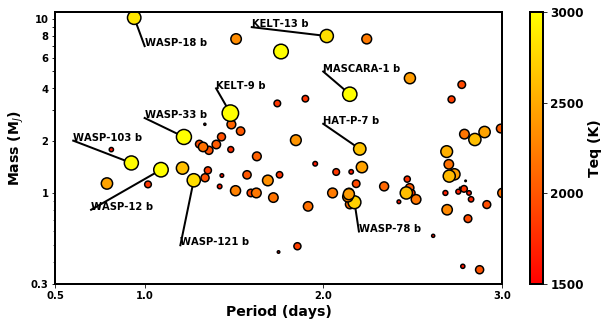

In [295]:
labeldict = {'WASP-18 b':(1.,7.), 'WASP-121 b':(1.2,0.5), 'WASP-103 b':(0.6,2), 'KELT-9 b':(1.4,4),\
             'WASP-33 b':(1.0,2.7), 'WASP-12 b': (0.7, 0.8), 'KELT-13 b':(1.6,9), \
            'MASCARA-1 b': (2.,5.), 'HAT-P-7 b': (2.,2.5), 'WASP-78 b': (2.2,0.6)}

y = 'MASS'
x = 'PER'
c = 'TEQ'

cm = p.cm.get_cmap('hot')

fig, ax = p.subplots()


sizes = (od['TEQ'] - 1500) / 1500. * 200

scax = ax.scatter(od[x], od[y], c=od[c], marker='o', 
          cmap='autumn', edgecolor='k', s=sizes, vmin=1500, vmax=3000, \
          lw = 1.5, zorder=-2)
p.xlabel('Period (days)', fontsize=14, weight='bold')
p.ylabel('Mass (M$_J$)', fontsize=14, weight='bold')

cbar = p.colorbar(scax, ticks=[1500,2000,2500,3000])
cbar.set_label(label='Teq (K)', fontsize=14, weight='bold')
cbar.ax.set_yticklabels([1500,2000,2500,3000], fontsize=12, weight='bold')
p.ylim([0.3,11.])
p.xlim([0.5,3])

ax.set_yscale("log", nonposy='clip')
ax.set_yticks([0.3,1,2,3,4,5,6,7,8,9,10])
ax.set_yticklabels([0.3,1,2,'',4,'',6,'',8,'',10], weight='bold')

ax.set_xticks([0.5,1.0,2.0,3.0])
ax.set_xticklabels([0.5,1.0,2.0,3.0], weight='bold')
p.rc('axes', linewidth=2)
ax.zorder = -10

for planet in od['NAME']:
    planet = get_planet(planet, od)
    if planet['MASS'] < .3: continue
    if planet['NAME'].startswith('KOI') or planet['NAME'].startswith('OGLE'): 
        continue
    if planet['PER'] > 2.3: continue
        
    if planet['TEQ'] > 2500.:
        #ax.text(planet[x]+.05, planet[y], planet['NAME'], \
        #      weight='bold', rotation=10, zorder=2, \
        #      bbox=dict(facecolor='w', edgecolor='black', boxstyle='round,pad=0.4', alpha=1, zorder=2))
        print planet['NAME']
        try: 
            label = labeldict[planet['NAME']]
            point = (planet[x], planet[y])
        except KeyError: 
            label = (planet[x]+0.05,planet[y])
            point = (planet[x], planet[y])
        add_label(ax, point, label, planet['NAME'], color='k', lw=2, zorder=-5)
        
#p.savefig('/home/jacob/Dropbox/plots/vhj_boxless.png', dpi=300, bbox_inches='tight')
p.show()

WASP-121 b (1.4, 1.3) WASP-103 b (0.55, 1.5) WASP-18 b (0.6, 2.4) HAT-P-7 b (2.25, 1.8) HAT-P-57 b (2.5, 2.15) Kepler-13 b (1.8, 2.2) WASP-82 b (2.8, 1.9) WASP-12 b (0.9, 2.2) WASP-100 b (3.0, 1.7) MASCARA-1 b (2.2, 2.5) MASCARA-2 b (3.0, 2.3) KELT-9 b (1.7, 2.6) KELT-13 b (2, 2) WASP-33 b (1.3, 2.0)

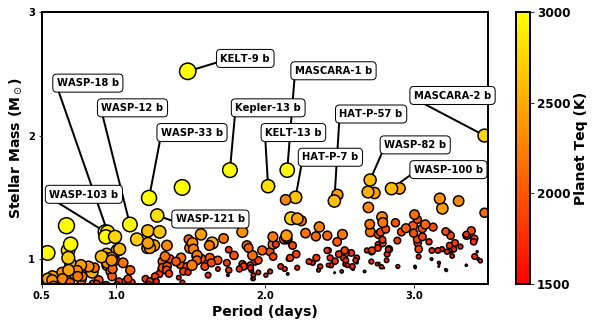

In [24]:
labeldict = {'WASP-18 b':(.6,2.4), 'WASP-121 b':(1.4,1.3), 'WASP-103 b':(0.55,1.5), 'KELT-9 b':(1.7,2.6),\
             'WASP-33 b':(1.3,2.), 'WASP-12 b': (.9, 2.2), 'KELT-13 b':(2,2), 'MASCARA-2 b':(3.,2.3), \
            'MASCARA-1 b': (2.2,2.5), 'HAT-P-7 b': (2.25,1.8), 'WASP-78 b': (1.7,1.45), \
             'OGLE-TR-56 b':(1.1,1.75), 'WASP-82 b':(2.8,1.9), 'WASP-100 b': (3.0,1.7), \
            'HAT-P-57 b': (2.5, 2.15), 'Kepler-13 b':(1.8,2.2)}

y = 'MSTAR'
x = 'PER'
c = 'TEQ'

rcParams['figure.figsize'] = 10, 5

cm = p.cm.get_cmap('hot')

fig, ax = p.subplots()


sizes = (od['TEQ'] - 1500) / 1500. * 200

scax = ax.scatter(od[x], od[y], c=od[c], marker='o', 
          cmap='autumn', edgecolor='k', s=sizes, vmin=1500, vmax=3000, \
          lw = 1.5, zorder=-2)
p.xlabel('Period (days)', fontsize=14, weight='bold')
p.ylabel('Stellar Mass (M$_\odot$)', fontsize=14, weight='bold')

cbar = p.colorbar(scax, ticks=[1500,2000,2500,3000])
cbar.set_label(label='Planet Teq (K)', fontsize=14, weight='bold')
cbar.ax.set_yticklabels([1500,2000,2500,3000], fontsize=12, weight='bold')
p.ylim([0.8,3.])
p.xlim([0.5,3.5])

#ax.set_yscale("log", nonposy='clip')
ax.set_yticks([1,2,3])
ax.set_yticklabels([1,2,3], weight='bold')

ax.set_xticks([0.5,1.0,2.0,3.0])
ax.set_xticklabels([0.5,1.0,2.0,3.0], weight='bold')
p.rc('axes', linewidth=2)
ax.zorder = -10

for planet in od['NAME']:
    planet = get_planet(planet, od)
    if planet['MASS'] < .3: continue
    if planet['NAME'] in ['WASP-78 b','HAT-P-49 b', 'OGLE-TR-56 b']: continue
    if planet['NAME'] == 'KOI-13 b':
        planet['NAME'] = 'Kepler-13 b'
    if planet['PER'] > 3.5: continue
        
    if planet['TEQ'] > 2500.:
        #ax.text(planet[x]+.05, planet[y], planet['NAME'], \
        #      weight='bold', rotation=10, zorder=2, \
        #      bbox=dict(facecolor='w', edgecolor='black', boxstyle='round,pad=0.4', alpha=1, zorder=2))
        try: 
            label = labeldict[planet['NAME']]
            point = (planet[x], planet[y])
        except KeyError: 
            label = (planet[x]+0.05,planet[y])
            point = (planet[x], planet[y])
        print planet['NAME'], label, 
        add_label(ax, point, label, planet['NAME'], color='k', lw=2, zorder=-5)
        
#p.savefig('/home/jacob/Dropbox/plots/vhj_mstar.png', dpi=300, bbox_inches='tight')
p.show()

# Kepler-1171 b, KOI-13 b

In [38]:
print get_planet('Kepler-1171 b', od)

{'A': 0.0291019, 'NAME': 'Kepler-1171 b', 'RSTAR': 1.95, 'PER': 1.44259224, 'R': 0.22800000000000001, 'MASS': 0.0203354, 'TEQ': 3307.175980430517, 'MSTAR': 1.5800000000000001, 'TEFF': 7044.0}
